# Catchment Scale Data Analysis

## 1. Preparing the data

In [82]:
## Importing library and setting up
library(stringr)
library(ggplot2)
library(dplyr)

rm(list=ls())

In [83]:
#change this to working directory
stew_name = "Strockhorsterdijk"
dir = paste("D:/Wageningen/Period 1/EDCA/Part 2/Stew", stew_name)
setwd(dir)

In [84]:
discharge = read.csv('Discharge.csv', skip=16, sep=";")
upstream = read.csv('Upstream.csv', skip=16, sep=";")
downstream = read.csv('Downstream.csv', skip=16, sep=";")
valve = read.csv('Valve.csv', skip=16, sep=";")

In [85]:
#rename columns
colnames(discharge)[1]="Date"
colnames(discharge)[2]="Value"

colnames(upstream)[1]="Date"
colnames(upstream)[2]="Value"

colnames(downstream)[1]="Date"
colnames(downstream)[2]="Value"

colnames(valve)[1]="Date"
colnames(valve)[2]="Value"

print(head(discharge))

                 Date Value
1 2010-08-22 15:00:00   ---
2 2010-08-22 16:00:00   ---
3 2010-08-22 17:00:00   ---
4 2010-08-22 18:00:00   ---
5 2010-08-22 19:00:00   ---
6 2010-08-22 20:00:00   ---


In [86]:
#filtering data
discharge$Value=str_trim(discharge$Value)
discharge$Value[discharge$Value == "---"] <- NA
discharge$Value = as.numeric(gsub(",", ".", gsub("\\.", "", discharge$Value)))

upstream$Value=str_trim(upstream$Value)
upstream$Value[upstream$Value == "---"] <- NA
upstream$Value = as.numeric(gsub(",", ".", gsub("\\.", "", upstream$Value)))

downstream$Value=str_trim(downstream$Value)
downstream$Value[downstream$Value == "---"] <- NA
downstream$Value = as.numeric(gsub(",", ".", gsub("\\.", "", downstream$Value)))

valve$Value=str_trim(valve$Value)
valve$Value[valve$Value == "---"] <- NA
valve$Value = as.numeric(gsub(",", ".", gsub("\\.", "", valve$Value)))

print(head(discharge))

                 Date Value
1 2010-08-22 15:00:00    NA
2 2010-08-22 16:00:00    NA
3 2010-08-22 17:00:00    NA
4 2010-08-22 18:00:00    NA
5 2010-08-22 19:00:00    NA
6 2010-08-22 20:00:00    NA


In [87]:
#changing date format to POSIXlt objects
discharge$Date <- as.POSIXlt(discharge$Date, format="%Y-%m-%d %H:%M:%S")
valve$Date <- as.POSIXlt(valve$Date, format="%Y-%m-%d %H:%M:%S")
upstream$Date <- as.POSIXlt(upstream$Date, format="%Y-%m-%d %H:%M:%S")
downstream$Date <- as.POSIXlt(downstream$Date, format="%Y-%m-%d %H:%M:%S")

In [88]:
#start and end full data
start_full <- min(discharge$Date[1],upstream$Date[1],valve$Date[1],downstream$Date[1])
end_full <- max(discharge$Date[length(discharge$Date)],upstream$Date[length(upstream$Date)],valve$Date[length(valve$Date)],downstream$Date[length(downstream$Date)])

#make full data
date_sequence <- seq(from = start_full, to = end_full, by = "hour")  
full_data <- data.frame(Date = date_sequence)

full_data <- left_join(full_data, discharge, by = "Date")
colnames(full_data)[2]="Discharge"

full_data <- left_join(full_data, downstream, by = "Date")
colnames(full_data)[3]="Downstream"

full_data <- left_join(full_data, upstream, by = "Date")
colnames(full_data)[4]="Upstream"

full_data <- left_join(full_data, valve, by = "Date")
colnames(full_data)[5]="Valve"

print(head(full_data))

summary(full_data)

                 Date Discharge Downstream Upstream Valve
1 2010-08-22 15:00:00        NA     17.035   17.654    NA
2 2010-08-22 16:00:00        NA     17.034   17.654    NA
3 2010-08-22 17:00:00        NA     17.034   17.654    NA
4 2010-08-22 18:00:00        NA     17.035   17.654    NA
5 2010-08-22 19:00:00        NA     17.035   17.655    NA
6 2010-08-22 20:00:00        NA     17.036   17.655    NA


      Date                       Discharge       Downstream       Upstream    
 Min.   :2010-08-22 15:00:00   Min.   :0.000   Min.   :16.77   Min.   :17.10  
 1st Qu.:2013-12-02 13:45:00   1st Qu.:0.001   1st Qu.:17.04   1st Qu.:17.72  
 Median :2017-03-14 13:30:00   Median :0.045   Median :17.18   Median :17.77  
 Mean   :2017-03-14 13:30:00   Mean   :0.096   Mean   :17.19   Mean   :17.72  
 3rd Qu.:2020-06-24 14:15:00   3rd Qu.:0.127   3rd Qu.:17.32   3rd Qu.:17.83  
 Max.   :2023-10-05 14:00:00   Max.   :2.089   Max.   :18.59   Max.   :18.61  
                               NA's   :24408   NA's   :23905   NA's   :23947  
     Valve      
 Min.   :17.69  
 1st Qu.:17.70  
 Median :17.73  
 Mean   :17.74  
 3rd Qu.:17.75  
 Max.   :17.96  
 NA's   :18926  

## 2. Filling the Data Using Q-h Relationship

In [89]:
#ommiting NA values and choosing only positive or 0 data
positive_full_data <- full_data[full_data$Upstream-full_data$Valve >= 0,]
positive_full_data <- na.omit(positive_full_data)

print(head(positive_full_data))

                     Date Discharge Downstream Upstream  Valve
12673 2012-02-01 14:00:00     0.070     17.268   17.789 17.735
12674 2012-02-01 15:00:00     0.071     17.267   17.790 17.736
12675 2012-02-01 16:00:00     0.071     17.267   17.790 17.736
12676 2012-02-01 17:00:00     0.069     17.268   17.789 17.736
12677 2012-02-01 18:00:00     0.068     17.268   17.788 17.735
12678 2012-02-01 19:00:00     0.067     17.268   17.786 17.734


In [90]:
#adding h (water level) column
options(repr.plot.width = 13)

positive_full_data$h = positive_full_data$Upstream-positive_full_data$Valve

print(head(positive_full_data))

                     Date Discharge Downstream Upstream  Valve     h
12673 2012-02-01 14:00:00     0.070     17.268   17.789 17.735 0.054
12674 2012-02-01 15:00:00     0.071     17.267   17.790 17.736 0.054
12675 2012-02-01 16:00:00     0.071     17.267   17.790 17.736 0.054
12676 2012-02-01 17:00:00     0.069     17.268   17.789 17.736 0.053
12677 2012-02-01 18:00:00     0.068     17.268   17.788 17.735 0.053
12678 2012-02-01 19:00:00     0.067     17.268   17.786 17.734 0.052


In [91]:
# Specify the file path where you want to save the CSV file
file_path <- paste("D:/Wageningen/Period 1/EDCA/Part 2/Stew ",stew_name,"/output.csv", sep="")

# Export the data frame to a CSV file
write.table(positive_full_data, file = file_path, row.names = FALSE, sep=";")

In [92]:
lm_model <- lm(Discharge ~ I(h^(3/2)) - 1, data = positive_full_data)
predicted_values <- predict(lm_model)

discharge_pred <- data.frame(h = seq(0, 0.6, length = 100))

discharge_pred$predicted_discharge <- predict(lm_model, newdata = discharge_pred)

prediction_intervals <- predict(lm_model, newdata = discharge_pred, interval = "prediction")

lower_bound <- prediction_intervals[, "lwr"]
upper_bound <- prediction_intervals[, "upr"]

discharge_pred$lower <- lower_bound
discharge_pred$upper <- upper_bound

head(discharge_pred)

,h,predicted_discharge,lower,upper
,<dbl>,<dbl>,<dbl>,<dbl>
1,0.000000000,0.000000000,-0.025156906,0.02515691
2,0.006060606,0.002584676,-0.022572230,0.02774158
3,0.012121212,0.007310569,-0.017846338,0.03246748
4,0.018181818,0.013430372,-0.011726535,0.03858728
5,0.024242424,0.020677411,-0.004479497,0.04583432
6,0.030303030,0.028897560,0.003740650,0.05405447


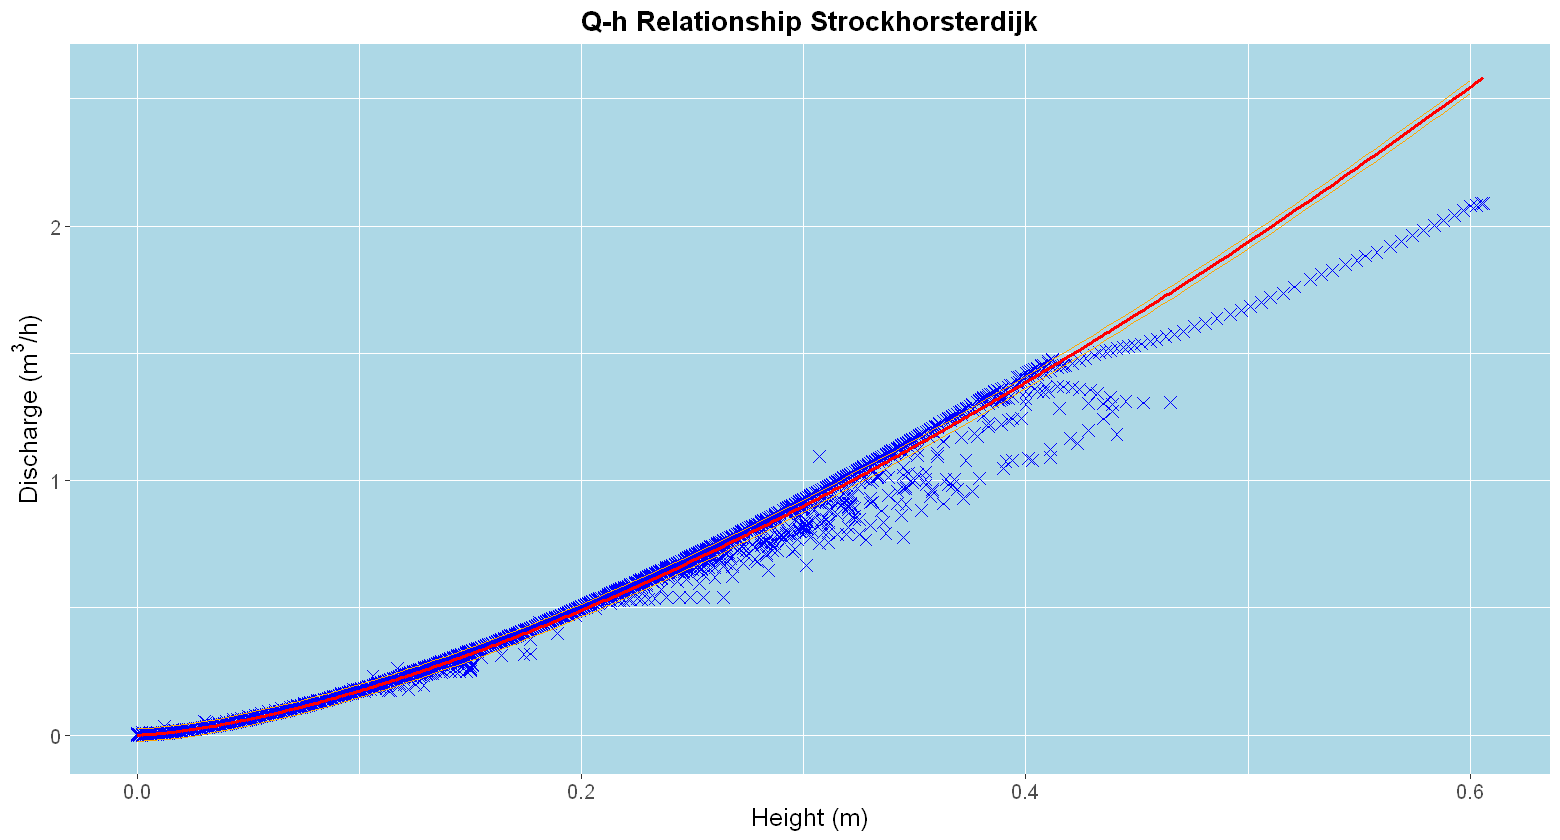

In [93]:
ggplot(positive_full_data, aes(x = h, y = Discharge)) +
  geom_point(shape = 4, size =3, color = "blue") +
  geom_line(data = discharge_pred, aes(x= h, y = lower), color = "#FFA500", linewidth = 0.5) +
  geom_line(data = discharge_pred, aes(x= h, y = upper), color = "#FFA500", linewidth = 0.5) +
  geom_line(aes(y = predicted_values), color = "red", linewidth = 1) +
  labs(x = "Height (m)", y = expression(paste("Discharge (", m^3,"/h)")))+
  theme(
      panel.background = element_rect(fill = "lightblue"),
      plot.title = element_text(hjust = 0.5, size=16, face ="bold"),
      axis.title.x = element_text(size = 15),               
      axis.title.y = element_text(size = 15),               
      axis.text.x = element_text(size = 12),                
      axis.text.y = element_text(size = 12)  
  ) +
  ggtitle(paste("Q-h Relationship", stew_name))

In [94]:
summary(lm_model)


Call:
lm(formula = Discharge ~ I(h^(3/2)) - 1, data = positive_full_data)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.49629  0.00066  0.00215  0.00413  0.16416 

Coefficients:
           Estimate Std. Error t value Pr(>|t|)    
I(h^(3/2)) 5.478127   0.001291    4243   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.01284 on 69866 degrees of freedom
Multiple R-squared:  0.9961,	Adjusted R-squared:  0.9961 
F-statistic: 1.8e+07 on 1 and 69866 DF,  p-value: < 2.2e-16


In [112]:
full_data$h = full_data$Upstream - full_data$Valve

filter_data = full_data[is.na(full_data$Discharge) & !is.na(full_data$h),]

a = data.frame(h=filter_data$h)

filter_data$Discharge = predict(lm_model, newdata = a)

fully_data = left_join(full_data, filter_data, by = "Date")

fully_data <- fully_data %>%
  mutate(Discharge.x = ifelse(!is.na(Discharge.y), Discharge.y, Discharge.x)) %>%
  select(-Discharge.y)  # Remove the extra column
  #mutate(Downstream.x = Downstream.x) %>%
  #select(-Downstream.y)
  #select(-Upstream.y)
  #select(-Valve.y)
  #select(-H.y)

fully_data

Date,Discharge.x,Downstream.x,Upstream.x,Valve.x,h.x,Downstream.y,Upstream.y,Valve.y,h.y
<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2010-08-22 15:00:00,NA,17.035,17.654,NA,NA,NA,NA,NA,NA
2010-08-22 16:00:00,NA,17.034,17.654,NA,NA,NA,NA,NA,NA
2010-08-22 17:00:00,NA,17.034,17.654,NA,NA,NA,NA,NA,NA
2010-08-22 18:00:00,NA,17.035,17.654,NA,NA,NA,NA,NA,NA
2010-08-22 19:00:00,NA,17.035,17.655,NA,NA,NA,NA,NA,NA
2010-08-22 20:00:00,NA,17.036,17.655,NA,NA,NA,NA,NA,NA
2010-08-22 21:00:00,NA,17.038,17.655,NA,NA,NA,NA,NA,NA
2010-08-22 22:00:00,NA,17.048,17.658,NA,NA,NA,NA,NA,NA
2010-08-22 23:00:00,NA,17.062,17.660,NA,NA,NA,NA,NA,NA


In [106]:
# Sample dataframes
df1 <- data.frame(id = c(1, 2, 3, 4),
                  value = c("A", "B", "C", "D"))

df2 <- data.frame(id = c(2, 3),
                  value = c("X", "Y"))

df1
df2
# Perform left join based on the 'id' column
result_df <- left_join(df1, df2, by = "id")

result_df
# Replace values in 'value.x' with corresponding values from 'value.y'
result_df <- result_df %>%
  mutate(value.x = ifelse(!is.na(value.y), value.y, value.x)) %>%
  select(-value.y)  # Remove the extra column

# Print the result
result_df

id,value
<dbl>,<chr>
1,A
2,B
3,C
4,D


id,value
<dbl>,<chr>
2,X
3,Y


id,value.x,value.y
<dbl>,<chr>,<chr>
1,A,NA
2,B,X
3,C,Y
4,D,NA


id,value.x
<dbl>,<chr>
1,A
2,X
3,Y
4,D


In [97]:
# Sample dataframe
df <- data.frame(A = c(1, 2, 3, 4, 5))

# Filter rows where column A is not equal to 3
filtered_df <- df[df$A != 3, ]

# Output the filtered dataframe
print(filtered_df)

[1] 1 2 4 5


In [98]:
#start and end period
start = "2015-01-01"
end = "2018-01-01"

Warning message:
"Removed 13 rows containing missing values (`geom_line()`)."
Warning message:
"Removed 13 rows containing missing values (`geom_line()`)."


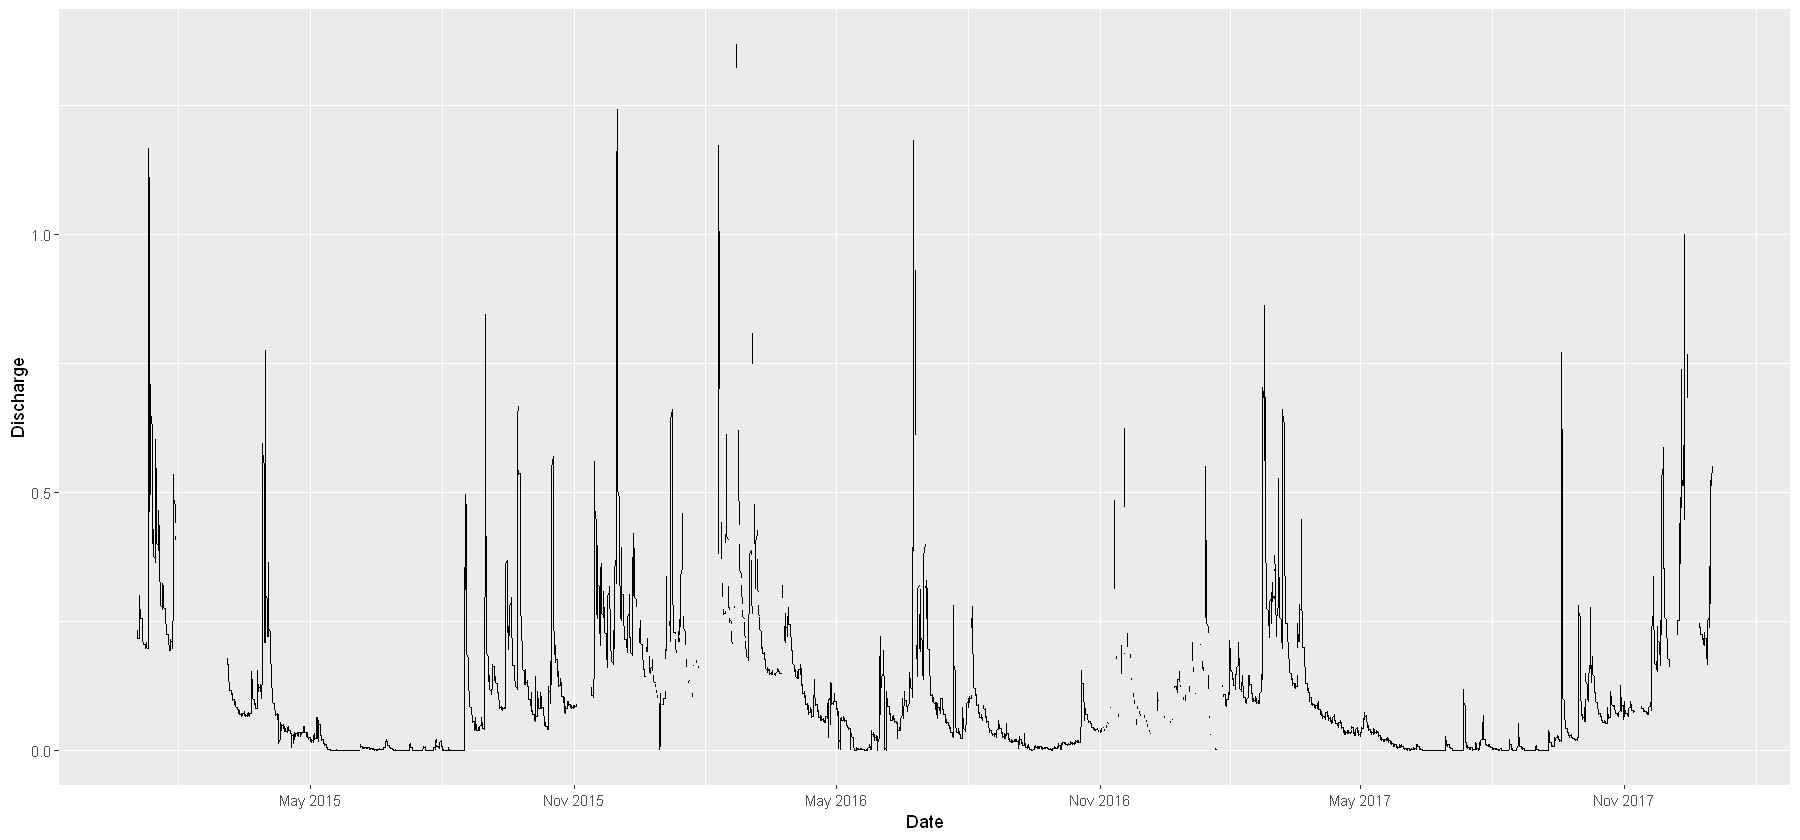

Warning message:
"Removed 13 rows containing missing values (`geom_line()`)."


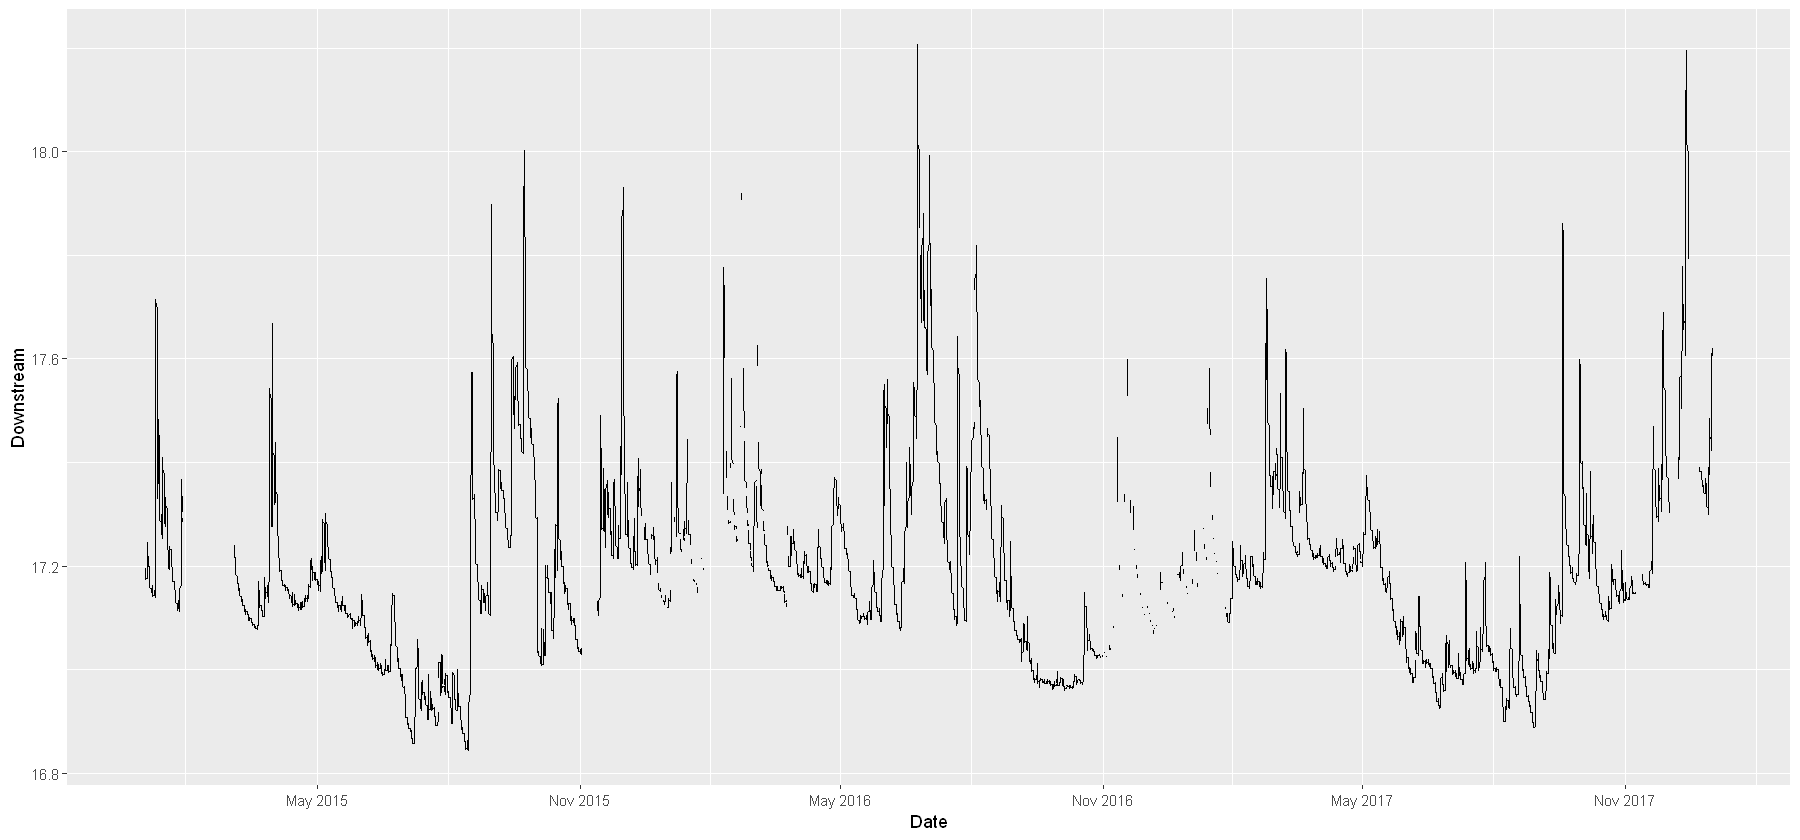

Warning message:
"Removed 12 rows containing missing values (`geom_line()`)."


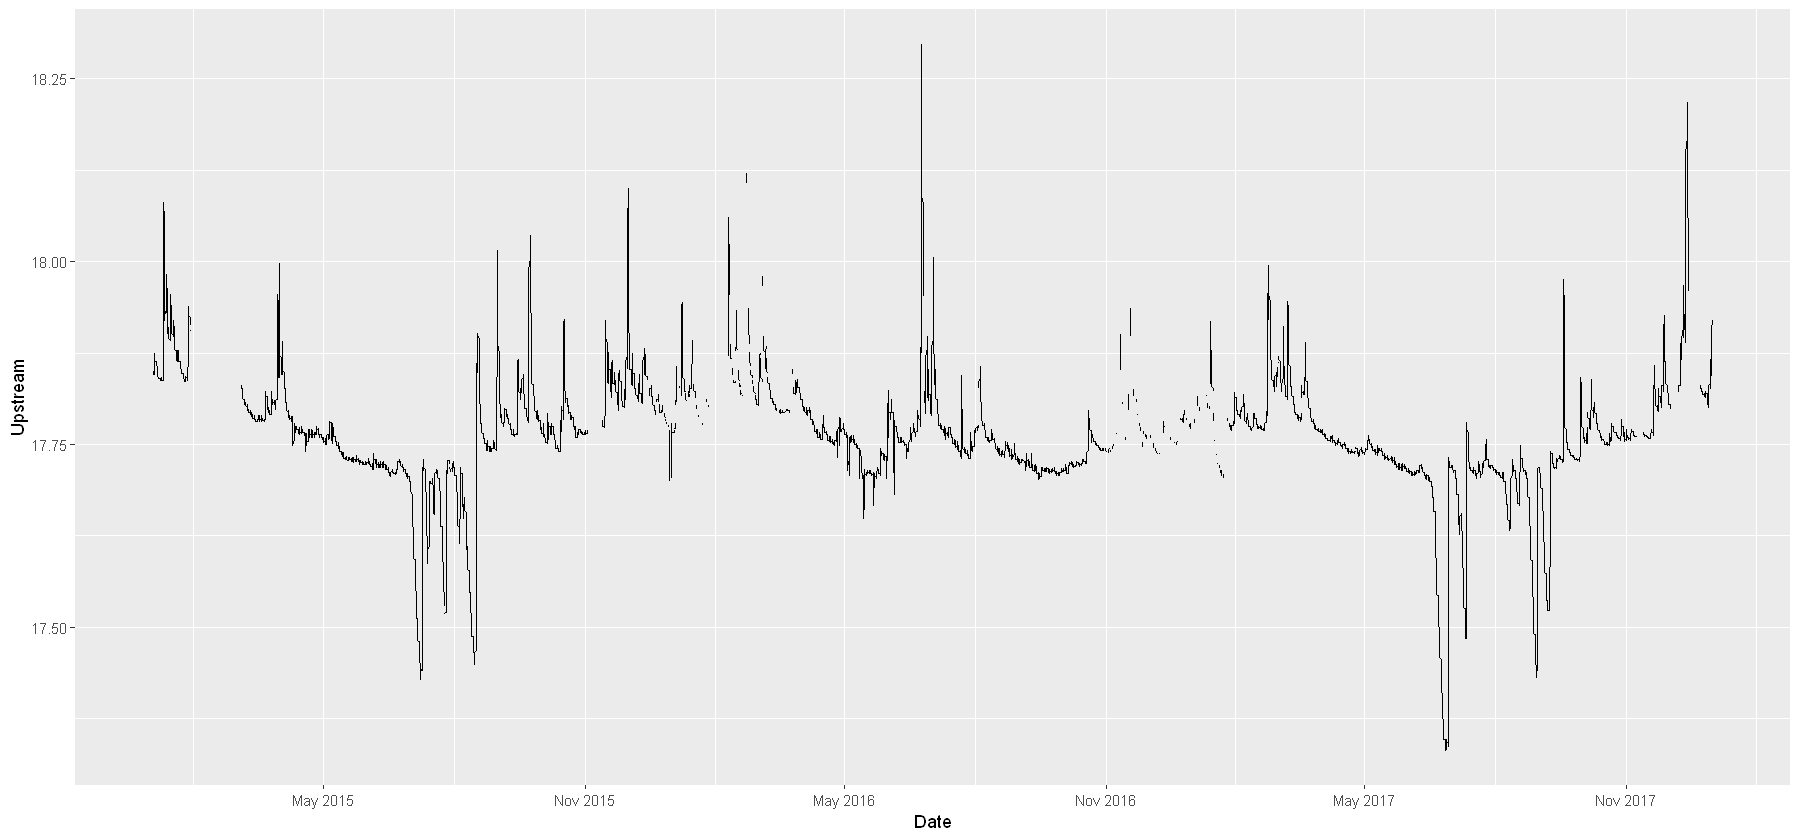

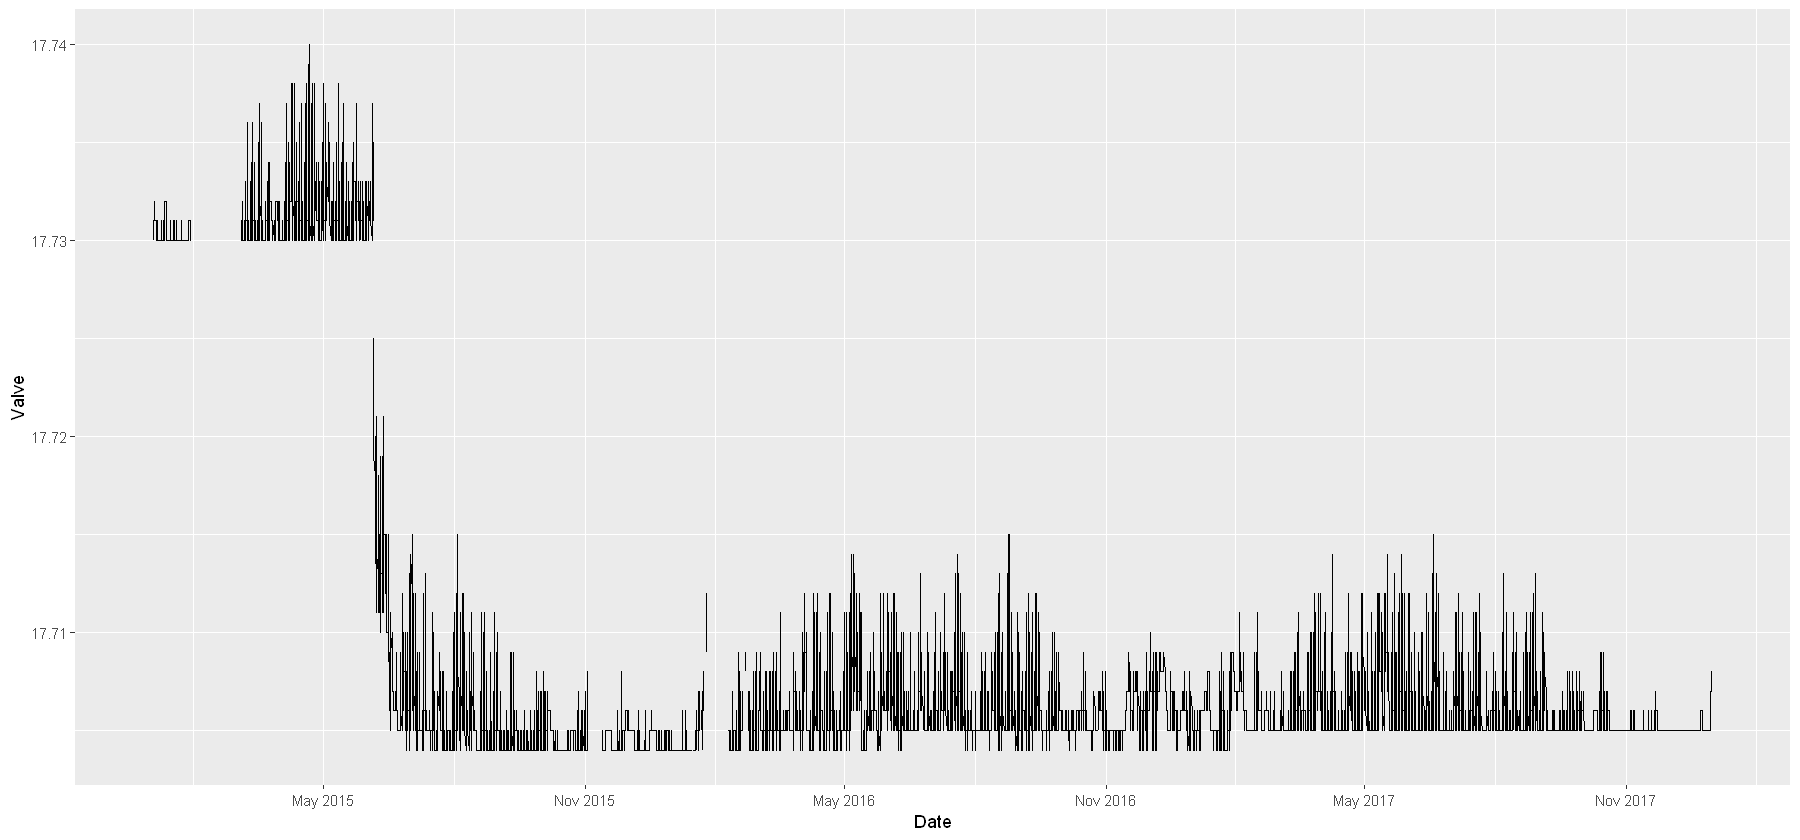

In [99]:
#plotting
options(repr.plot.width = 15)

discharge_subset <- discharge[discharge$Date >= as.POSIXlt(start) & discharge$Date <= as.POSIXlt(end), ]
downstream_subset <- downstream[downstream$Date >= as.POSIXlt(start) & downstream$Date <= as.POSIXlt(end), ]
upstream_subset <- upstream[upstream$Date >= as.POSIXlt(start) & upstream$Date <= as.POSIXlt(end), ]
valve_subset <- valve[valve$Date >= as.POSIXlt(start) & valve$Date <= as.POSIXlt(end), ]

#plotting ggplot
ggplot(discharge_subset, aes(x = as.Date(Date), y = Value)) +
  geom_line() +
  labs(y = "Discharge", x = "Date") +
  scale_x_date(date_labels = "%b %Y", date_breaks = "6 months")

ggplot(downstream_subset, aes(x = as.Date(Date), y = Value)) +
  geom_line() +
  labs(y = "Downstream", x = "Date") +
  scale_x_date(date_labels = "%b %Y", date_breaks = "6 months")

ggplot(upstream_subset, aes(x = as.Date(Date), y = Value)) +
  geom_line() +
  labs(y = "Upstream", x = "Date") +
  scale_x_date(date_labels = "%b %Y", date_breaks = "6 months")

ggplot(valve_subset, aes(x = as.Date(Date), y = Value)) +
  geom_line() +
  labs(y = "Valve", x = "Date") +
  scale_x_date(date_labels = "%b %Y", date_breaks = "6 months")


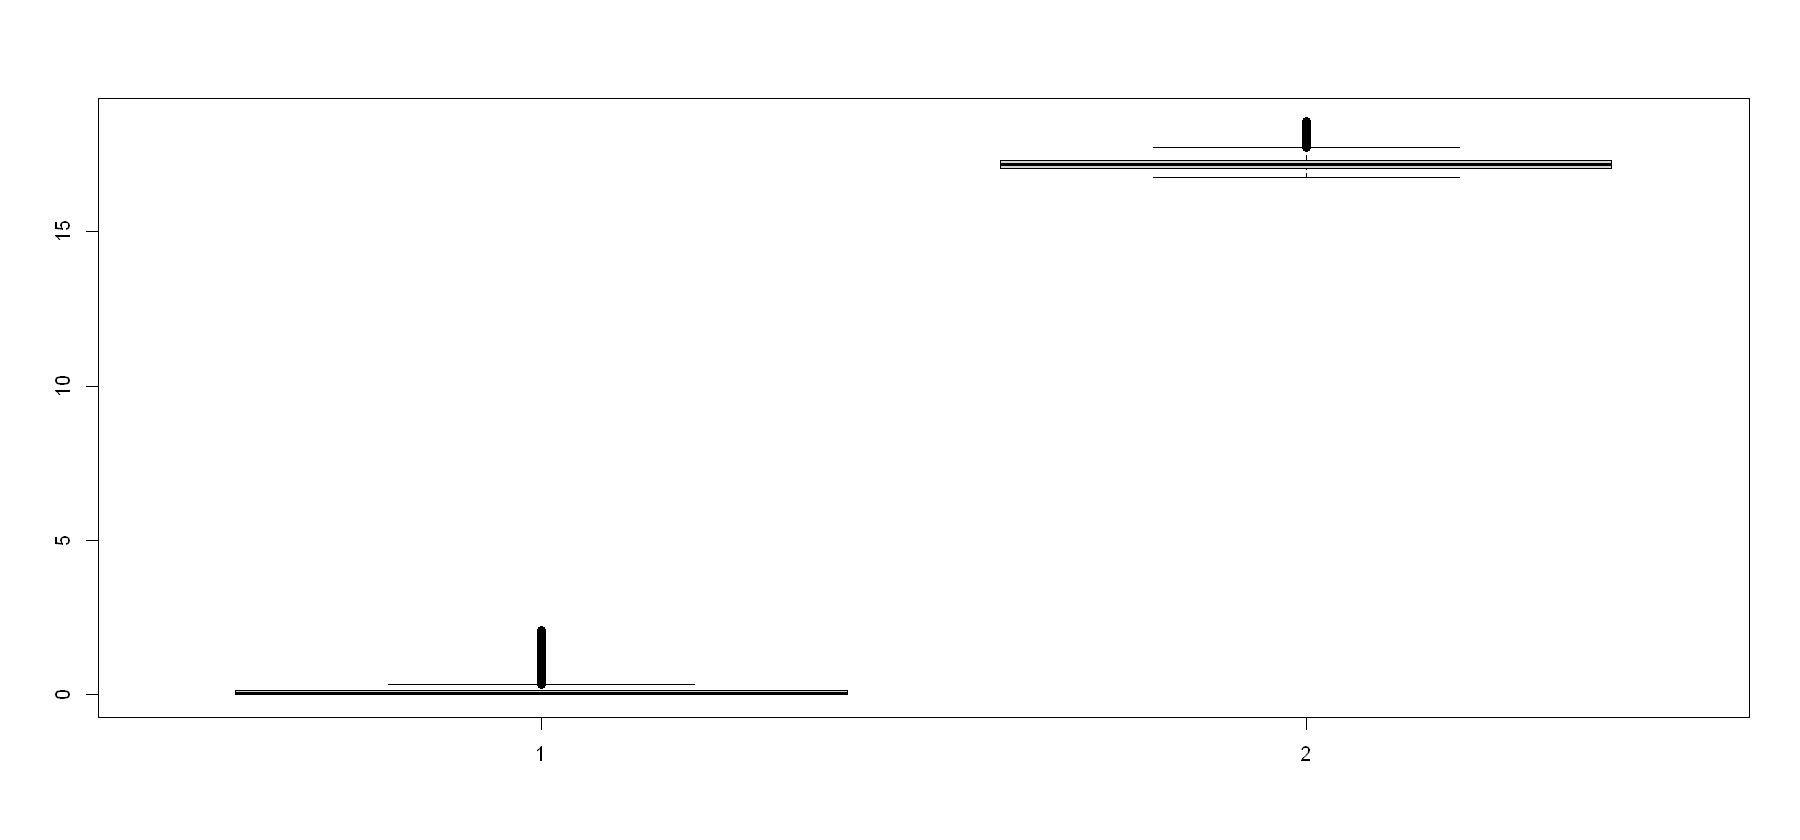

In [100]:
boxplot(full_data$Discharge,full_data$Downstream)